In [36]:
import numpy as np
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def cluster_baseline(X):
    kmeans = KMeans(n_clusters=5, random_state=1)
    kmeans.fit(X)
    return kmeans

def decision_tree_baseline(X, y):
    tree = DecisionTreeClassifier(criterion='entropy')
    tree.fit(X, y)
    return tree


In [37]:
from sklearn.model_selection import GridSearchCV
# Replace the following with your own functions that are better than the baseline versions defined in the cell above
cluster = cluster_baseline
decision_tree = decision_tree_baseline

###
### YOUR CODE HERE
###

def cluster(data, n_clusters=8):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters))
    ])
    pipeline.fit(data)
    return pipeline


def decision_tree(X_train, y_train):
    
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', DecisionTreeClassifier())
    ])
    
    
    param_grid = {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 5, 10, 15],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
    
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    
    best_estimator = grid_search.best_estimator_
    
    
    decision_tree_classifier = best_estimator.named_steps['clf']
    
    return decision_tree_classifier

In [38]:
# Load data and keep only numeric entries
fname = os.path.join('..', 'resource', 'asnlib', 'publicdata', 'fight-songs.csv')
data = pd.read_csv(fname, index_col='school').replace({'Yes': 1, 'No': 0, 'Unknown': None}).dropna()
data['year'] = pd.to_numeric(data['year'])
X = data.drop(columns=['conference', 'song_name', 'writers', 'spotify_id'])

cluster1 = cluster(X.drop(columns='year'))
cluster2 = cluster_baseline(X.drop(columns='year'))

def cluster_prediction_score(X, field, cluster_fun):
    """Compute mean squared error over cluster-based predictions of 'year'"""
    X_train = X.drop(columns=field)
    clustering = cluster_fun(X_train)
    X['cluster'] = clustering.predict(X_train)
    error = 0
    for C in set(list(X['cluster'])):
        # Find cluster over entire data set
        C_data = X[X['cluster'] == C]
        for school in C_data.index:
            # Compute mean value for this cluster minus the school being predicted
            val_pred = C_data.drop(school)[field].mean()
            val_real = X.filter(items=[school], axis=0)[field]
            error += (val_pred-val_real).pow(2).mean()
    return error/len(X)

# Compute errors for solution and baseline clustering methods
error1 = cluster_prediction_score(X, 'year', cluster)
X = X.drop(columns='cluster')
error2 = cluster_prediction_score(X, 'year', cluster_baseline)
X = X.drop(columns='cluster')

print(f'Your method achieved a mean squared distance of {int(error1)}, compared to the baseline of {int(error2)}')
score = (error1-error2)/error2
assert score < 0, f'Your method was {int(100*score)}% worse'
print(f'Your method was {-int(100*score)}% better')

Your method achieved a mean squared distance of 329, compared to the baseline of 383
Your method was 14% better


In [39]:
assert score < -0.1, 'This was not enough to earn further points'
print('This was good enough to earn further points')

This was good enough to earn further points


In [40]:
assert score < -0.25, 'This was not enough to earn further points'
print('This was good enough to earn max points')

AssertionError: This was not enough to earn further points

/usr/local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


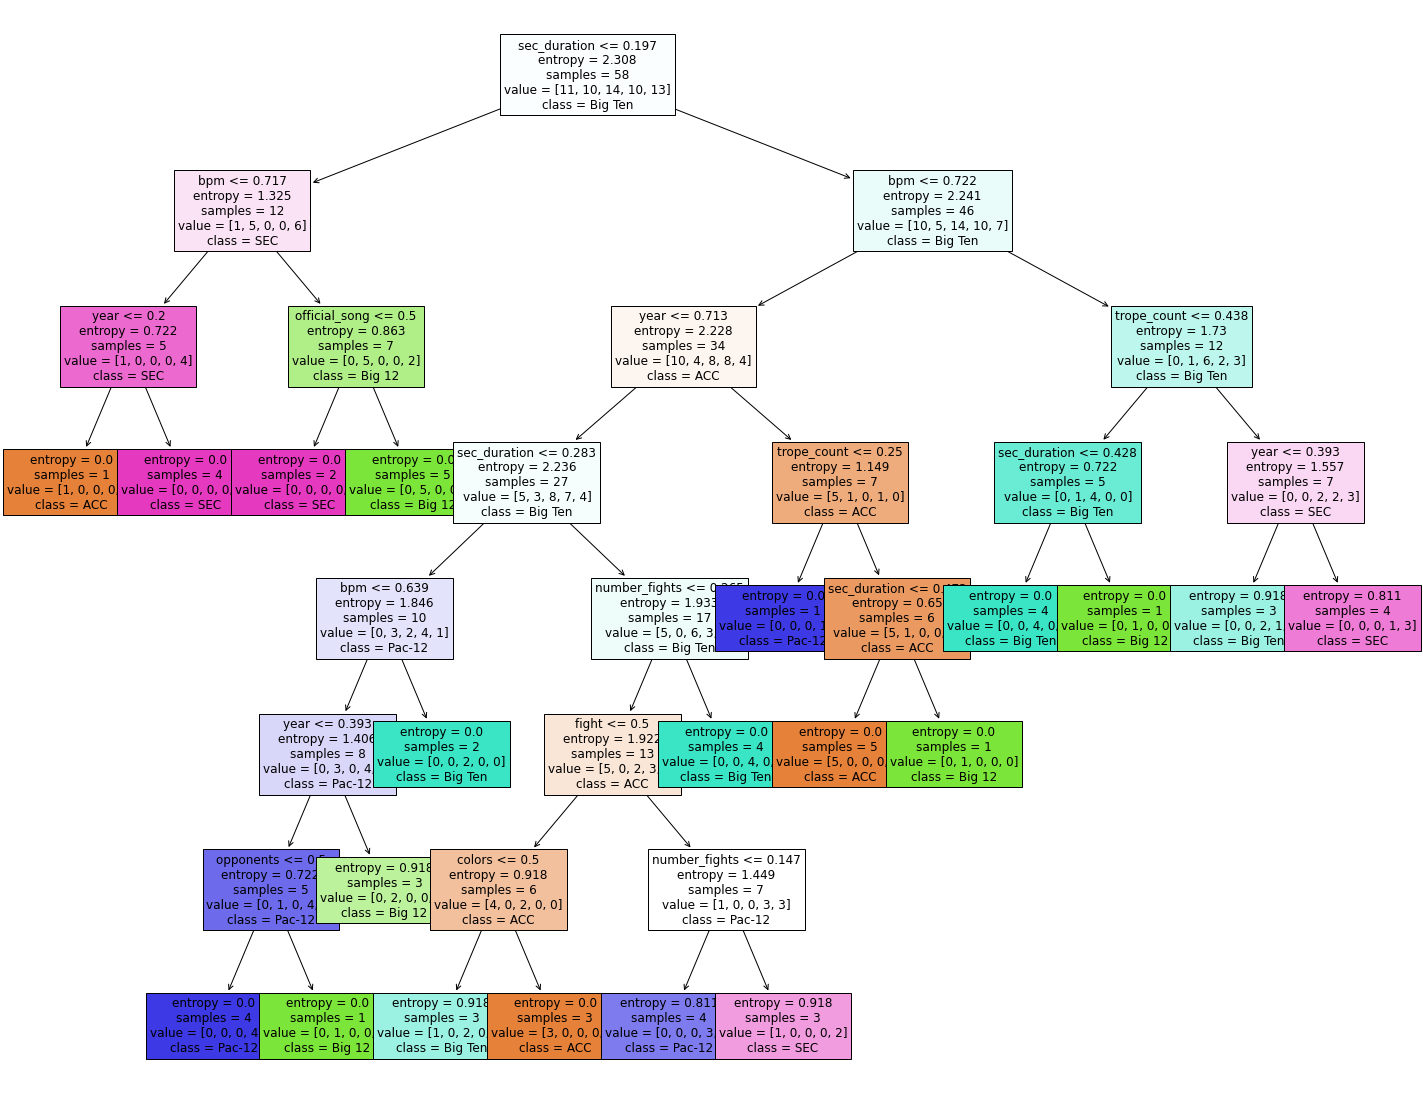

Your decision tree gave a 0.25 higher probability to the correct answer over the baseline


In [41]:
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os
import pandas as pd

def score_trees(X_train, y_train, X_test, y_test, draw_plot=False):
    # Train solution and baseline decision trees
    clf1 = decision_tree(X_train, y_train)
    clf2 = decision_tree_baseline(X_train, y_train)
    # Generate solution and baseline predictions
    predict1 = clf1.predict_proba(X_test)
    predict2 = clf2.predict_proba(X_test)
    # Total up probability for correct answer, between solution and baseline predictions
    score = 0
    for i, dist1 in enumerate(predict1):
        dist2 = predict2[i]
        # This is the correct conference
        j = conferences.index(y_test[i])
        # Compare the probability assigned to the correct conference between the two prediction distributions
        score += dist1[j]-dist2[j]
    if draw_plot: plot_tree(clf1)
    return score

def plot_tree(clf):
    """Plot solution tree"""
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(clf, 
                   feature_names=X.columns,
                   class_names=conferences,
                   filled=True,
                   fontsize=12)
    plt.show()

# Load data and keep only numeric entries
fname = os.path.join('..', 'resource', 'asnlib', 'publicdata', 'fight-songs.csv')
data = pd.read_csv(fname, index_col='school').replace({'Yes': 1, 'No': 0, 'Unknown': None, 'Independent': None}).dropna()
data['year'] = pd.to_numeric(data['year'])
X = data.drop(columns=['conference', 'song_name', 'writers', 'spotify_id'])
y = data['conference']

# What are the conferences (in the decision-tree output form)
clf2 = decision_tree_baseline(X, y)
conferences = list(clf2.classes_)

X_train = X.drop('UCLA')
y_train = y.drop('UCLA')
X_test = X.filter(items=['UCLA'], axis=0)
y_test = y.filter(items=['UCLA'], axis=0)

score = score_trees(X_train, y_train, X_test, y_test, True)
    
assert score > 0, f'Your decision tree did not improve over the baseline ({-score:.02f} worse)'
print(f'Your decision tree gave a {score:0.2f} higher probability to the correct answer over the baseline')

In [42]:
assert score > 0.1, 'This was not enough to earn further points'
print('This was good enough to earn further points')

This was good enough to earn further points


In [43]:
assert score > 0.2, 'This was not enough to earn the max points'
print('This was good enough to earn max points')

This was good enough to earn max points
